In [46]:
from ds import *
from trainer import *
from losses import *
from networks import *

from skimage.metrics import structural_similarity as ssim
from skimage.metrics import peak_signal_noise_ratio as psnr

import os
from torch.utils.data import DataLoader

os.environ["CUDA_VISIBLE_DEVICES"] = "1"

DATA_PATH = '/home/PET-CT/splited_data_15k'
IMAGE_SIZE = 256
CT_MAX = 2047
PET_MAX = 32767
BATCH_SIZE = 1

In [47]:
def get_image_paths_from_dir(fdir):
    flist = os.listdir(fdir)
    flist.sort()
    image_paths = []
    for i in range(0, len(flist)):
        fpath = os.path.join(fdir, flist[i])
        if os.path.isdir(fpath):
            image_paths.extend(get_image_paths_from_dir(fpath))
        else:
            image_paths.append(fpath)
    return image_paths

def get_dataset_by_stage(data_path, stage, image_size, ct_max_pixel, pet_max_pixel, flip):
    ct_paths = get_image_paths_from_dir(os.path.join(data_path, f'{stage}/A'))
    pet_paths = get_image_paths_from_dir(os.path.join(data_path, f'{stage}/B'))

    return PETCTDataset(ct_paths, pet_paths, image_size, ct_max_pixel, pet_max_pixel, flip)

In [48]:
train_dataset = get_dataset_by_stage(DATA_PATH, 'train', (IMAGE_SIZE, IMAGE_SIZE), CT_MAX, PET_MAX, True)
val_dataset = get_dataset_by_stage(DATA_PATH, 'val', (IMAGE_SIZE, IMAGE_SIZE), CT_MAX, PET_MAX, False)
test_dataset = get_dataset_by_stage(DATA_PATH, 'test', (IMAGE_SIZE, IMAGE_SIZE), CT_MAX, PET_MAX, False)

train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=16)
valid_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=16)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=16)

In [49]:
CKPT_PATH = '/home/PET-CT/thaind/medical-image-translation/UncerGuidedI2I/ckpt/CT2PET_CasUNet_3head_block1_G_best_mape_10093.70298949962.pth'

netG_A = CasUNet_3head(1,1)
netG_A.load_state_dict(torch.load(CKPT_PATH))
netG_A.type(torch.FloatTensor)
netG_A.eval()

CasUNet_3head(
  (unet_list): ModuleList(
    (0): UNet_3head(
      (inc): ResConv(
        (double_conv): Sequential(
          (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
          (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (5): ReLU(inplace=True)
          (6): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (7): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (8): ReLU(inplace=True)
        )
        (double_conv1): Sequential(
          (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU(inplace=Tr

In [50]:
# avg_mae = []
# avg_mape = []

# with torch.no_grad():
#     for i, batch in enumerate(test_dataloader):
#         xA, xB = batch[0].type(torch.FloatTensor), batch[1].type(torch.FloatTensor)
        
#         rec_B, rec_alpha_B, rec_beta_B = netG_A(xA)
        
#         n = xB.shape[0]
        
#         for t in range(n):
#             pet_pred = rec_B[t].cpu().numpy()
#             pet_gt = xB[t].cpu().numpy()
        
#             mae = compute_mae(pet_gt, pet_pred)
#             mape = compute_mape(1 - pet_gt, 1 - pet_pred)
        
#             avg_mae.append(mae)
#             avg_mape.append(mape)
            
#             print(mae, mape)
            
#             break
    
# avg_mae = np.mean(avg_mae)
# avg_mape = np.mean(avg_mape)

# print(avg_mae, avg_mape)

tensor(0.) tensor(1.)
tensor(0.) tensor(0.5005)


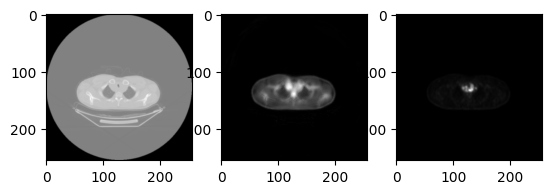

SSIM: 0.9137329641565699
PSNR: 28.082969362852488
MAE: 414.9024353027344
MAPE: 924.9186401367188
tensor(0.) tensor(1.0000)
tensor(0.) tensor(0.5405)


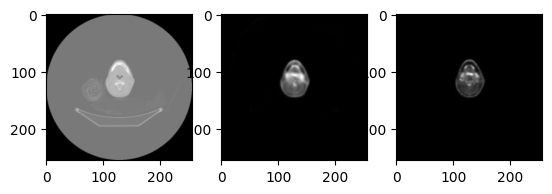

SSIM: 0.9781272749325018
PSNR: 34.374273981443196
MAE: 103.18926239013672
MAPE: 27.63739585876465
tensor(0.) tensor(1.)
tensor(0.) tensor(0.6802)


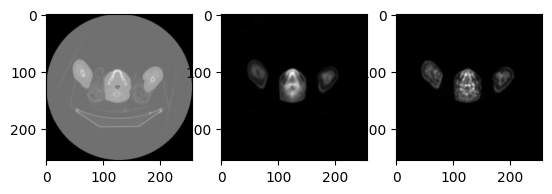

SSIM: 0.9484984020862169
PSNR: 30.536698977334055
MAE: 241.70191955566406
MAPE: 782.05029296875
tensor(0.) tensor(1.)
tensor(0.) tensor(0.6722)


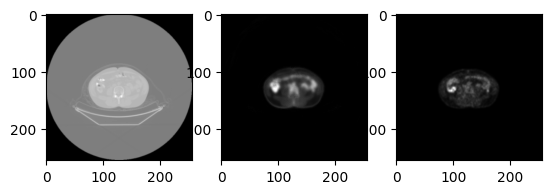

SSIM: 0.9559809645005092
PSNR: 32.36668078763064
MAE: 163.1153564453125
MAPE: 653.6622314453125
tensor(0.) tensor(1.0000)
tensor(0.) tensor(0.5408)


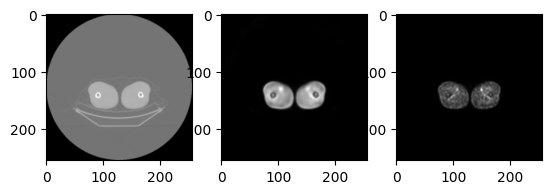

SSIM: 0.9649590076578467
PSNR: 34.60014536638069
MAE: 138.0333251953125
MAPE: 27.435731887817383
Avg SSIM: 0.9522597226667289
Avg PSNR: 31.992153695128213
Avg MAE: 212.18844604492188
Avg MAPE: 483.140869140625


In [52]:
# DISPLAY_OFFSET = 50
DISPLAY_OFFSET = 123

test_nsample = 5
# test_nsample = len(test_dataloader)

ssim_avg = 0
psnr_avg = 0
mae_avg = 0
mape_avg = 0

for i in range(test_nsample):
    test_data = list(test_dataloader)[i * DISPLAY_OFFSET]

    ct, pet_gt = test_data[0], test_data[1]

    ct = ct.type(torch.FloatTensor)

    with torch.no_grad():
        pet_pred, _, _ = netG_A(ct)
        
        ct = ct.squeeze(0).squeeze(0)
        pet_pred = pet_pred.clamp_(0, 1.)
        pet_pred = pet_pred.squeeze(0).squeeze(0)
        pet_gt = pet_gt.squeeze(0).squeeze(0)

        ssim_score = ssim(pet_pred.numpy(),
                      pet_gt.numpy(),
                      data_range=1)
        
        psnr_score = psnr(pet_pred.numpy(),
                      pet_gt.numpy(),
                      data_range=1)
        print(pet_gt.min(), pet_gt.max())
        print(pet_pred.min(), pet_pred.max())
        mae = compute_mae(pet_gt, pet_pred)
        mape = compute_mape(1 - pet_gt, 1 - pet_pred)

        plt.figure()
        plt.subplot(1,3,1)
        plt.imshow(ct, cmap='gray')
        plt.subplot(1,3,2)
        plt.imshow(pet_pred, cmap='gray')
        plt.subplot(1,3,3)
        plt.imshow(pet_gt, cmap='gray')
        plt.show()

        print('SSIM: {}'.format(ssim_score))
        print('PSNR: {}'.format(psnr_score))
        print('MAE: {}'.format(mae * 32767))
        print('MAPE: {}'.format(mape))
        
        ssim_avg += ssim_score
        psnr_avg += psnr_score
        mae_avg += mae
        mape_avg += mape

ssim_avg /= test_nsample
psnr_avg /= test_nsample
mae_avg /= test_nsample
mape_avg /= test_nsample

print('Avg SSIM: {}'.format(ssim_avg))
print('Avg PSNR: {}'.format(psnr_avg))
print('Avg MAE: {}'.format(mae_avg * 32767))
print('Avg MAPE: {}'.format(mape_avg))

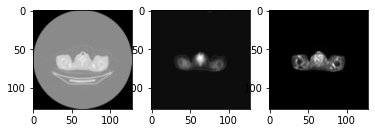

SSIM: 0.8952395692104179
PSNR: 22.76934676811883


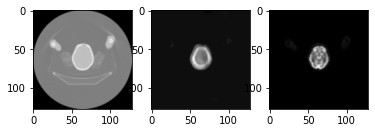

SSIM: 0.9253387606553785
PSNR: 24.40541275799044


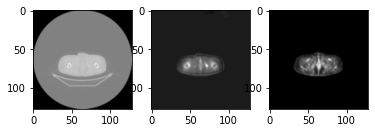

SSIM: 0.8611455553238887
PSNR: 20.01666583811666


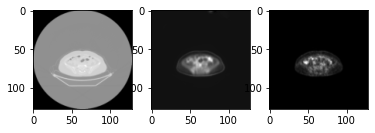

SSIM: 0.934457616990814
PSNR: 27.118730680380487


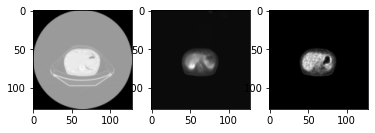

SSIM: 0.9346935378745777
PSNR: 22.73538919938167


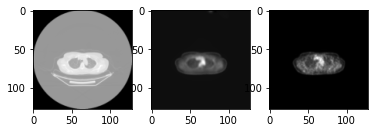

SSIM: 0.9521940852663218
PSNR: 26.806024774166186


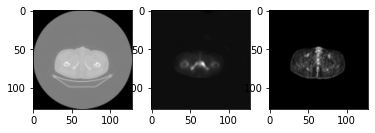

SSIM: 0.8053262537039166
PSNR: 21.80252315634484


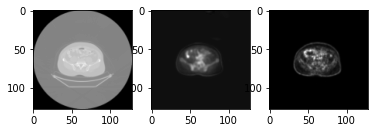

SSIM: 0.8393580502610205
PSNR: 23.06052242386261


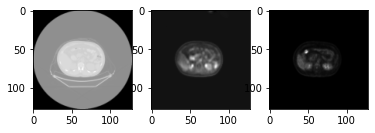

SSIM: 0.9279125537237136
PSNR: 30.07911135062077


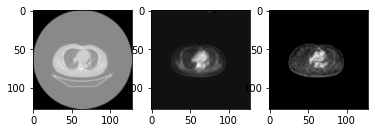

SSIM: 0.8287488419823279
PSNR: 21.165556986870016
Avg SSIM: 0.8904414824992377
Avg PSNR: 23.995928393585253


In [10]:
netG_A1 = CasUNet_3head(1,1)
netG_A1.load_state_dict(torch.load('../ckpt/I2I_CasUNet3headGAN_G_1_0.0001_best.pth'))
netG_A1.type(torch.FloatTensor)
netG_A1.eval()

netG_A2 = UNet_3head(4,1)
netG_A2.load_state_dict(torch.load('../ckpt/I2I_Sequence_CasUNet3headGAN_Block2_G_0.5_0.001_best.pth'))
netG_A2.type(torch.FloatTensor)
netG_A2.eval()

list_netG_A = [netG_A1, netG_A2]

DISPLAY_OFFSET = 50
# DISPLAY_OFFSET = 1

test_nsample = 10
# test_nsample = len(test_loader)

ssim_avg = 0
psnr_avg = 0

for i in range(test_nsample):
    test_data = test_loader[i * DISPLAY_OFFSET]

    pet_img, ct_img = test_data['pet'], test_data['ct']
    pet_min, pet_max = test_data['pet_min'], test_data['pet_max']
    ct_min, ct_max = test_data['ct_min'], test_data['ct_max']

    ct_img = ct_img.type(torch.FloatTensor)

    for nid, netG in enumerate(list_netG_A):
        if nid == 0:
            rec_B, rec_alpha_B, rec_beta_B = netG(ct_img)
        else:
            xch = torch.cat([rec_B, rec_alpha_B, rec_beta_B, ct_img], dim=1)
            rec_B, rec_alpha_B, rec_beta_B = netG(xch)

    with torch.no_grad():
        pred_img = rec_B

        pet_img = pet_img.squeeze(0)
        ct_img = ct_img.squeeze(0)
        pred_img = pred_img.squeeze(0)

        ssim_score = ssim(pet_img.numpy().transpose([1, 2, 0]),
                      pred_img.numpy().transpose([1, 2, 0]), channel_axis=-1,
                      data_range=1)

        pet_img = pet_img.squeeze(0)
        ct_img = ct_img.squeeze(0)
        pred_img = pred_img.squeeze(0)

        pet_img = unscale_image(pet_img.numpy(), [pet_min, pet_max])
        ct_img = unscale_image(ct_img.numpy(), [ct_min, ct_max])
        pred_img = unscale_image(pred_img.numpy(), [pet_min, pet_max])

        mse = np.sum((pred_img - pet_img) ** 2) / pet_img.size
        data_range = pet_img.max() - pet_img.min()
        psnr_score = 10 * np.log10((data_range ** 2) / mse)

        plt.figure()
        plt.subplot(1,3,1)
        plt.imshow(ct_img, cmap='gray')
        plt.subplot(1,3,2)
        plt.imshow(pred_img, cmap='gray')
        plt.subplot(1,3,3)
        plt.imshow(pet_img, cmap='gray')
        plt.show()

        print('SSIM: {}'.format(ssim_score))
        print('PSNR: {}'.format(psnr_score))

        ssim_avg += ssim_score
        psnr_avg += psnr_score

ssim_avg /= test_nsample
psnr_avg /= test_nsample

print('Avg SSIM: {}'.format(ssim_avg))
print('Avg PSNR: {}'.format(psnr_avg))

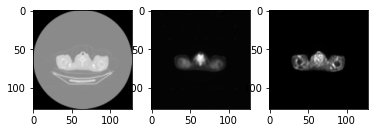

SSIM: 0.8933210542732943
PSNR: 23.047363737286165


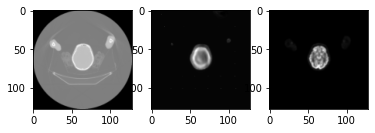

SSIM: 0.9170741428638316
PSNR: 23.41599130739743


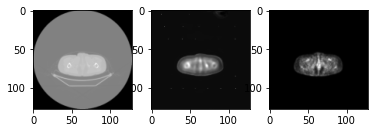

SSIM: 0.8629452793765153
PSNR: 20.662707459295305


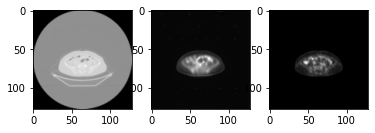

SSIM: 0.9440092850838921
PSNR: 28.42746571678152


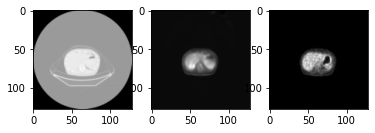

SSIM: 0.9399548198482197
PSNR: 24.056054266129706


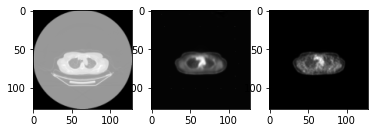

SSIM: 0.9608098222888418
PSNR: 28.359660844511176


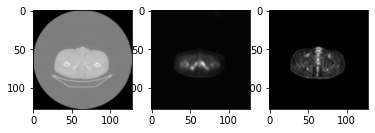

SSIM: 0.8139123709097561
PSNR: 22.83965726606229


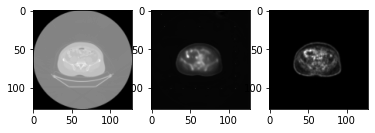

SSIM: 0.8453176344937727
PSNR: 23.84746583275875


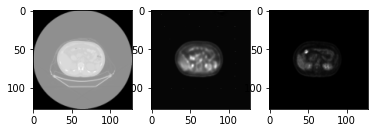

SSIM: 0.91491275757362
PSNR: 28.8344649673026


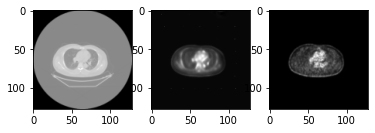

SSIM: 0.8279988230599167
PSNR: 21.23147842607495
SSIM: 0.8920255989771659
PSNR: 24.472230982359992


In [12]:
netG_A1 = CasUNet_3head(1,1)
netG_A1.load_state_dict(torch.load('../ckpt/I2I_CasUNet3headGAN_G_1_0.0001_best.pth'))
netG_A1.type(torch.FloatTensor)
netG_A1.eval()

netG_A2 = UNet_3head(4,1)
netG_A2.load_state_dict(torch.load('../ckpt/I2I_Sequence_CasUNet3headGAN_Block2_G_0.5_0.001_best.pth'))
netG_A2.type(torch.FloatTensor)
netG_A2.eval()

netG_A3 = UNet_3head(4,1)
netG_A3.load_state_dict(torch.load('../ckpt/I2I_Sequence_CasUNet3headGAN_Block3_G_0.1_0.01_best.pth'))
netG_A3.type(torch.FloatTensor)
netG_A3.eval()

list_netG_A = [netG_A1, netG_A2, netG_A3]

DISPLAY_OFFSET = 50
# DISPLAY_OFFSET = 1

test_nsample = 10
# test_nsample = len(test_loader)

ssim_avg = 0
psnr_avg = 0

for i in range(test_nsample):
    test_data = test_loader[i * DISPLAY_OFFSET]

    pet_img, ct_img = test_data['pet'], test_data['ct']
    pet_min, pet_max = test_data['pet_min'], test_data['pet_max']
    ct_min, ct_max = test_data['ct_min'], test_data['ct_max']

    ct_img = ct_img.type(torch.FloatTensor)

    for nid, netG in enumerate(list_netG_A):
        if nid == 0:
            rec_B, rec_alpha_B, rec_beta_B = netG(ct_img)
        else:
            xch = torch.cat([rec_B, rec_alpha_B, rec_beta_B, ct_img], dim=1)
            rec_B, rec_alpha_B, rec_beta_B = netG(xch)

    with torch.no_grad():
        pred_img = rec_B

        pet_img = pet_img.squeeze(0)
        ct_img = ct_img.squeeze(0)
        pred_img = pred_img.squeeze(0)

        ssim_score = ssim(pet_img.numpy().transpose([1, 2, 0]),
                      pred_img.numpy().transpose([1, 2, 0]), channel_axis=-1,
                      data_range=1)

        pet_img = pet_img.squeeze(0)
        ct_img = ct_img.squeeze(0)
        pred_img = pred_img.squeeze(0)

        pet_img = unscale_image(pet_img.numpy(), [pet_min, pet_max])
        ct_img = unscale_image(ct_img.numpy(), [ct_min, ct_max])
        pred_img = unscale_image(pred_img.numpy(), [pet_min, pet_max])

        mse = np.sum((pred_img - pet_img) ** 2) / pet_img.size
        data_range = pet_img.max() - pet_img.min()
        psnr_score = 10 * np.log10((data_range ** 2) / mse)

        plt.figure()
        plt.subplot(1,3,1)
        plt.imshow(ct_img, cmap='gray')
        plt.subplot(1,3,2)
        plt.imshow(pred_img, cmap='gray')
        plt.subplot(1,3,3)
        plt.imshow(pet_img, cmap='gray')
        plt.show()

        print('SSIM: {}'.format(ssim_score))
        print('PSNR: {}'.format(psnr_score))

        ssim_avg += ssim_score
        psnr_avg += psnr_score

ssim_avg /= test_nsample
psnr_avg /= test_nsample

print('SSIM: {}'.format(ssim_avg))
print('PSNR: {}'.format(psnr_avg))